In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os 

2023-02-18 13:02:38.710915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 13:02:43.480322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-18 13:02:43.480401: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-18 13:02:55.886445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
data_dir = 'test_videos'
train_dir = os.path.join('train_frames')

test_dir = os.path.join('test_frames')

In [3]:
#Datasets parameters
BATCH_SIZE = 32
IMG_SIZE = (224,224)

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7850 files belonging to 11 classes.


2023-02-18 13:03:20.874377: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-18 13:03:20.883119: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-18 13:03:20.883249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hena029): /proc/driver/nvidia/version does not exist
2023-02-18 13:03:20.884414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 7673 files belonging to 11 classes.


In [5]:
#Configure dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
#Use data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [7]:
#Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [10]:
base_model.trainable = False

In [11]:
print(base_model.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [12]:
#Classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(100, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 100)


In [14]:

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
#compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [17]:
initial_epochs = 30
loss0, accuracy0 = model.evaluate(test_dataset)

/home/hena/.local/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


240/240 [==============================] - 172s 702ms/step - loss: 4.9924 - accuracy: 0.0050


In [18]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 4.99
initial accuracy: 0.00


In [19]:
initial_epochs = 30
loss0, accuracy0 = model.evaluate(train_dataset)

246/246 [==============================] - 174s 703ms/step - loss: 4.9733 - accuracy: 0.0048


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.97
initial accuracy: 0.00


In [28]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=test_dataset)

Epoch 1/30
246/246 [==============================] - 492s 2s/step - loss: 2.6149 - accuracy: 0.1629 - val_loss: 2.3046 - val_accuracy: 0.1839
Epoch 2/30
246/246 [==============================] - 541s 2s/step - loss: 2.0217 - accuracy: 0.3182 - val_loss: 1.8828 - val_accuracy: 0.4027
Epoch 3/30
246/246 [==============================] - 534s 2s/step - loss: 1.6274 - accuracy: 0.4683 - val_loss: 1.6830 - val_accuracy: 0.4466
Epoch 4/30
246/246 [==============================] - 647s 3s/step - loss: 1.3668 - accuracy: 0.5539 - val_loss: 1.4498 - val_accuracy: 0.5104
Epoch 5/30
246/246 [==============================] - 526s 2s/step - loss: 1.1562 - accuracy: 0.6290 - val_loss: 1.4349 - val_accuracy: 0.5074
Epoch 6/30
246/246 [==============================] - 549s 2s/step - loss: 0.9922 - accuracy: 0.6899 - val_loss: 1.2711 - val_accuracy: 0.5684
Epoch 7/30
246/246 [==============================] - 566s 2s/step - loss: 0.8436 - accuracy: 0.7324 - val_loss: 1.2283 - val_accuracy: 0.5736

2023-02-18 14:43:32.146469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 177 of 256
2023-02-18 14:43:34.732341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 559s 2s/step - loss: 0.5728 - accuracy: 0.8236 - val_loss: 1.0171 - val_accuracy: 0.6597
Epoch 11/30
246/246 [==============================] - 561s 2s/step - loss: 0.5158 - accuracy: 0.8469 - val_loss: 0.9275 - val_accuracy: 0.6754
Epoch 12/30
246/246 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.8642

2023-02-18 15:02:35.674811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 108 of 256
2023-02-18 15:02:41.140911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 587s 2s/step - loss: 0.4499 - accuracy: 0.8642 - val_loss: 0.8644 - val_accuracy: 0.7019
Epoch 13/30
246/246 [==============================] - 583s 2s/step - loss: 0.3905 - accuracy: 0.8855 - val_loss: 0.8970 - val_accuracy: 0.6941
Epoch 14/30
246/246 [==============================] - 570s 2s/step - loss: 0.3483 - accuracy: 0.8981 - val_loss: 0.9007 - val_accuracy: 0.6902
Epoch 15/30
246/246 [==============================] - 734s 3s/step - loss: 0.3311 - accuracy: 0.9003 - val_loss: 0.8210 - val_accuracy: 0.7172
Epoch 16/30
246/246 [==============================] - 584s 2s/step - loss: 0.2975 - accuracy: 0.9085 - val_loss: 0.7304 - val_accuracy: 0.7545
Epoch 17/30
246/246 [==============================] - 706s 3s/step - loss: 0.2706 - accuracy: 0.9183 - val_loss: 0.6829 - val_accuracy: 0.7632
Epoch 18/30
246/246 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9292

2023-02-18 16:07:07.089086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 188 of 256
2023-02-18 16:07:08.624038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 715s 3s/step - loss: 0.2405 - accuracy: 0.9292 - val_loss: 0.8607 - val_accuracy: 0.7207
Epoch 19/30
246/246 [==============================] - 701s 3s/step - loss: 0.2237 - accuracy: 0.9334 - val_loss: 0.7655 - val_accuracy: 0.7456
Epoch 20/30
246/246 [==============================] - 637s 3s/step - loss: 0.1995 - accuracy: 0.9427 - val_loss: 0.8674 - val_accuracy: 0.7107
Epoch 21/30


2023-02-18 16:34:15.027666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 224 of 256
2023-02-18 16:34:16.716016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 507s 2s/step - loss: 0.1825 - accuracy: 0.9451 - val_loss: 0.6692 - val_accuracy: 0.7764
Epoch 22/30
246/246 [==============================] - 528s 2s/step - loss: 0.1640 - accuracy: 0.9538 - val_loss: 0.7215 - val_accuracy: 0.7629
Epoch 23/30
246/246 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.9587

2023-02-18 16:56:31.808537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 52 of 256
2023-02-18 16:56:42.120114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 185 of 256
2023-02-18 16:56:48.504485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 526s 2s/step - loss: 0.1557 - accuracy: 0.9587 - val_loss: 0.8596 - val_accuracy: 0.7069
Epoch 24/30


2023-02-18 17:00:15.555816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 226 of 256
2023-02-18 17:00:17.244480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 520s 2s/step - loss: 0.1452 - accuracy: 0.9601 - val_loss: 0.6449 - val_accuracy: 0.7900
Epoch 25/30
246/246 [==============================] - 525s 2s/step - loss: 0.1321 - accuracy: 0.9614 - val_loss: 0.6103 - val_accuracy: 0.7926
Epoch 26/30
246/246 [==============================] - 488s 2s/step - loss: 0.1245 - accuracy: 0.9639 - val_loss: 0.6595 - val_accuracy: 0.7794
Epoch 27/30
246/246 [==============================] - 494s 2s/step - loss: 0.1134 - accuracy: 0.9679 - val_loss: 0.6674 - val_accuracy: 0.7812
Epoch 28/30
246/246 [==============================] - 481s 2s/step - loss: 0.1056 - accuracy: 0.9671 - val_loss: 0.5742 - val_accuracy: 0.8074
Epoch 29/30
246/246 [==============================] - 494s 2s/step - loss: 0.1024 - accuracy: 0.9720 - val_loss: 0.6267 - val_accuracy: 0.7958
Epoch 30/30


2023-02-18 17:50:21.827769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 256
2023-02-18 17:50:32.283492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 140 of 256
2023-02-18 17:50:35.834961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 512s 2s/step - loss: 0.0836 - accuracy: 0.9767 - val_loss: 0.6683 - val_accuracy: 0.7864


In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

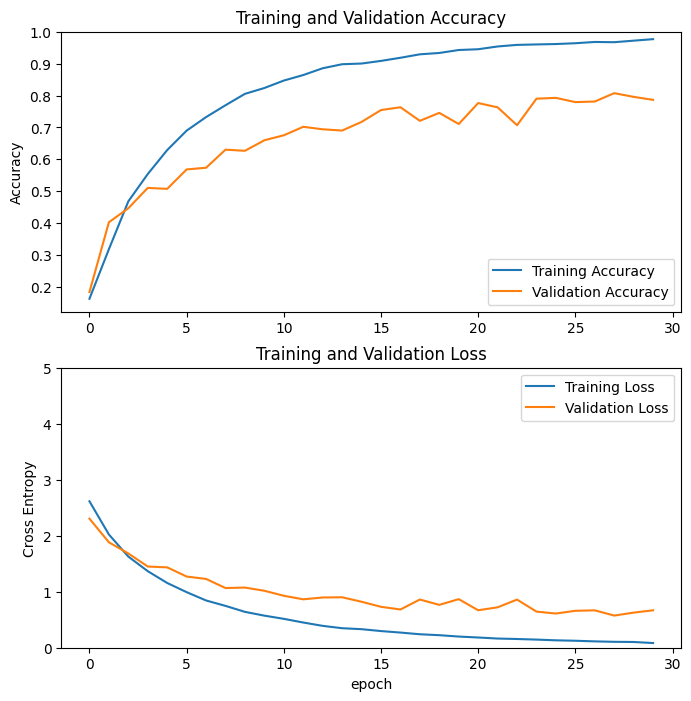

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
base_model.trainable = True

In [33]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [34]:
fine_tune_at = 100

In [35]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [36]:
#Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [37]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

In [38]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 30/60
246/246 [==============================] - 671s 2s/step - loss: 0.0872 - accuracy: 0.9752 - val_loss: 0.6256 - val_accuracy: 0.7861
Epoch 31/60
246/246 [==============================] - 588s 2s/step - loss: 0.0745 - accuracy: 0.9794 - val_loss: 0.6689 - val_accuracy: 0.7668
Epoch 32/60
246/246 [==============================] - 746s 3s/step - loss: 0.0695 - accuracy: 0.9805 - val_loss: 0.6349 - val_accuracy: 0.7872
Epoch 33/60


2023-02-19 00:08:18.078077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 48 of 256
2023-02-19 00:08:28.849917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 251 of 256
2023-02-19 00:08:28.902264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9815

2023-02-19 00:14:14.626144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 92 of 256
2023-02-19 00:14:24.318810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 561s 2s/step - loss: 0.0652 - accuracy: 0.9815 - val_loss: 0.6142 - val_accuracy: 0.7975
Epoch 34/60
246/246 [==============================] - 524s 2s/step - loss: 0.0654 - accuracy: 0.9805 - val_loss: 0.5776 - val_accuracy: 0.8115
Epoch 35/60


2023-02-19 00:26:23.722291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 28 of 256
2023-02-19 00:26:33.660994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 162 of 256
2023-02-19 00:26:40.712921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 566s 2s/step - loss: 0.0574 - accuracy: 0.9845 - val_loss: 0.5309 - val_accuracy: 0.8222
Epoch 36/60
246/246 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9845

2023-02-19 00:42:18.504789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 149 of 256
2023-02-19 00:42:23.595684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 555s 2s/step - loss: 0.0566 - accuracy: 0.9845 - val_loss: 0.6866 - val_accuracy: 0.7766
Epoch 37/60
246/246 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9837

2023-02-19 00:51:48.356960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 243 of 256
2023-02-19 00:51:49.057327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 577s 2s/step - loss: 0.0554 - accuracy: 0.9837 - val_loss: 0.6401 - val_accuracy: 0.7893
Epoch 38/60
246/246 [==============================] - 655s 3s/step - loss: 0.0529 - accuracy: 0.9860 - val_loss: 0.6262 - val_accuracy: 0.7985
Epoch 39/60
246/246 [==============================] - 587s 2s/step - loss: 0.0491 - accuracy: 0.9856 - val_loss: 0.6040 - val_accuracy: 0.8026
Epoch 40/60
246/246 [==============================] - 615s 3s/step - loss: 0.0434 - accuracy: 0.9876 - val_loss: 0.7598 - val_accuracy: 0.7692
Epoch 41/60
246/246 [==============================] - 539s 2s/step - loss: 0.0417 - accuracy: 0.9879 - val_loss: 0.5412 - val_accuracy: 0.8233
Epoch 42/60
246/246 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9890

2023-02-19 01:42:28.220290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 126 of 256
2023-02-19 01:42:31.140184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 611s 2s/step - loss: 0.0404 - accuracy: 0.9890 - val_loss: 0.6534 - val_accuracy: 0.7921
Epoch 43/60
246/246 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9883

2023-02-19 01:51:50.595923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 14 of 256
2023-02-19 01:51:58.926272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 27 of 256
2023-02-19 01:52:08.414994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 154 of 256
2023-02-19 01:52:18.670778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 222 of 256
2023-02-19 01:52:24.564026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 604s 2s/step - loss: 0.0374 - accuracy: 0.9883 - val_loss: 0.7261 - val_accuracy: 0.7715
Epoch 44/60


2023-02-19 01:56:24.927133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 17 of 256
2023-02-19 01:56:33.620155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 256
2023-02-19 01:56:43.247940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 151 of 256
2023-02-19 01:56:49.961970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9901

2023-02-19 02:02:06.715880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 34 of 256
2023-02-19 02:02:14.686052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 231 of 256
2023-02-19 02:02:15.308074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 547s 2s/step - loss: 0.0351 - accuracy: 0.9901 - val_loss: 0.5640 - val_accuracy: 0.8135
Epoch 45/60
246/246 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9907

2023-02-19 02:10:56.750043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 93 of 256
2023-02-19 02:11:06.748984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 204 of 256
2023-02-19 02:11:08.999605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 549s 2s/step - loss: 0.0336 - accuracy: 0.9907 - val_loss: 0.5329 - val_accuracy: 0.8169
Epoch 46/60
246/246 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9921

2023-02-19 02:19:58.238564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 143 of 256
2023-02-19 02:20:09.668102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 214 of 256
2023-02-19 02:20:16.779050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 530s 2s/step - loss: 0.0282 - accuracy: 0.9921 - val_loss: 0.4715 - val_accuracy: 0.8458
Epoch 47/60
246/246 [==============================] - 518s 2s/step - loss: 0.0310 - accuracy: 0.9912 - val_loss: 0.6509 - val_accuracy: 0.7954
Epoch 48/60
246/246 [==============================] - 534s 2s/step - loss: 0.0312 - accuracy: 0.9906 - val_loss: 0.5330 - val_accuracy: 0.8280
Epoch 49/60
246/246 [==============================] - 517s 2s/step - loss: 0.0278 - accuracy: 0.9918 - val_loss: 0.4925 - val_accuracy: 0.8385
Epoch 50/60


2023-02-19 02:49:39.694829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 27 of 256
2023-02-19 02:49:49.547728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 128 of 256
2023-02-19 02:49:58.278605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 608s 2s/step - loss: 0.0254 - accuracy: 0.9934 - val_loss: 0.4783 - val_accuracy: 0.8417
Epoch 51/60
246/246 [==============================] - 535s 2s/step - loss: 0.0273 - accuracy: 0.9916 - val_loss: 0.4618 - val_accuracy: 0.8518
Epoch 52/60


2023-02-19 03:08:44.053291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 34 of 256
2023-02-19 03:08:53.923620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 255 of 256
2023-02-19 03:08:53.923752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9932

2023-02-19 03:14:45.436467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 256
2023-02-19 03:14:54.198472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 81 of 256
2023-02-19 03:15:04.326552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 135 of 256
2023-02-19 03:15:14.267538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 190 of 256
2023-02-19 03:15:17.280754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 619s 2s/step - loss: 0.0239 - accuracy: 0.9932 - val_loss: 0.4738 - val_accuracy: 0.8441
Epoch 53/60
246/246 [==============================] - 557s 2s/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.5853 - val_accuracy: 0.8222
Epoch 54/60


2023-02-19 03:28:18.908294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 110 of 256
2023-02-19 03:28:26.798852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 588s 2s/step - loss: 0.0240 - accuracy: 0.9929 - val_loss: 0.6684 - val_accuracy: 0.8058
Epoch 55/60
246/246 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9941

2023-02-19 03:44:23.336384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 256
2023-02-19 03:44:32.248192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 44 of 256
2023-02-19 03:44:42.427028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 107 of 256
2023-02-19 03:44:52.318931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 228 of 256
2023-02-19 03:44:57.760577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 636s 3s/step - loss: 0.0211 - accuracy: 0.9941 - val_loss: 0.5534 - val_accuracy: 0.8256
Epoch 56/60
246/246 [==============================] - 558s 2s/step - loss: 0.0224 - accuracy: 0.9939 - val_loss: 0.4705 - val_accuracy: 0.8444
Epoch 57/60


2023-02-19 03:58:46.329834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 256
2023-02-19 03:58:56.161804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 94 of 256
2023-02-19 03:59:06.277145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 238 of 256
2023-02-19 03:59:07.174600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 552s 2s/step - loss: 0.0166 - accuracy: 0.9955 - val_loss: 0.6093 - val_accuracy: 0.8134
Epoch 58/60


2023-02-19 04:07:58.219433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 111 of 256
2023-02-19 04:08:03.819594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9953

2023-02-19 04:13:06.528354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 19 of 256
2023-02-19 04:13:16.470331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 174 of 256
2023-02-19 04:13:26.467284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 250 of 256
2023-02-19 04:13:26.821632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 510s 2s/step - loss: 0.0182 - accuracy: 0.9953 - val_loss: 0.4946 - val_accuracy: 0.8437
Epoch 59/60


2023-02-19 04:16:35.465143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11 of 256
2023-02-19 04:16:38.702933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 35 of 256
2023-02-19 04:16:48.727927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 122 of 256
2023-02-19 04:17:00.756292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 184 of 256
2023-02-19 04:17:05.185621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9936

2023-02-19 04:22:38.741371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 140 of 256
2023-02-19 04:22:45.296730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 569s 2s/step - loss: 0.0209 - accuracy: 0.9936 - val_loss: 0.5012 - val_accuracy: 0.8366
Epoch 60/60


2023-02-19 04:25:57.735091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 121 of 256
2023-02-19 04:26:05.180224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 510s 2s/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.4462 - val_accuracy: 0.8495


In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

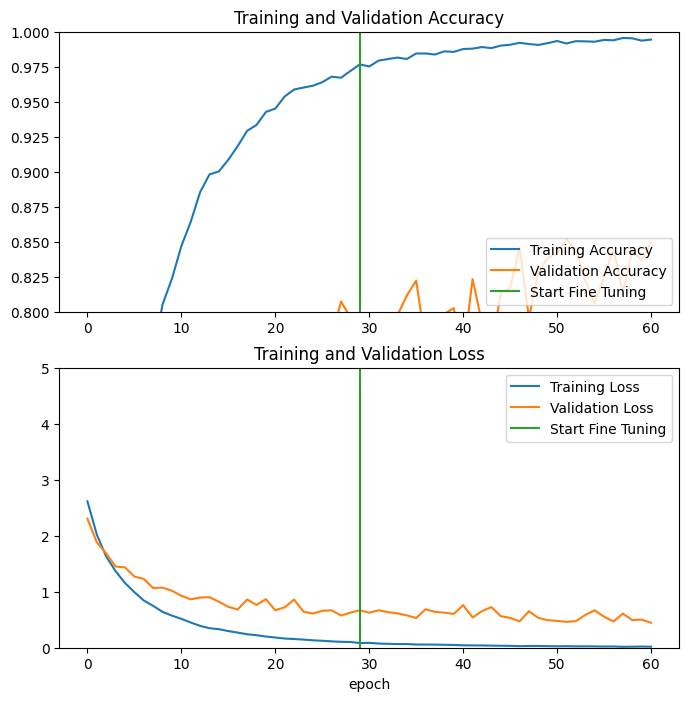

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

240/240 [==============================] - 176s 716ms/step - loss: 0.4462 - accuracy: 0.8495
Test accuracy : 0.849472165107727


In [43]:
loss, accuracy = model.evaluate(train_dataset)
print('Train accuracy :', accuracy)

246/246 [==============================] - 183s 727ms/step - loss: 0.4371 - accuracy: 0.8525
Train accuracy : 0.8524840474128723
